## Workshop 1 - Report

In this report, I shall give an overview of what we learned from the 'Local filed potential (LFP)' section of 'Module 1: Neural data handling and preprocessing'. 

Additionally, I provide my resolution of exercises 1 and 3 although we are asked to hand-in only one. My motivation concerns a result I have in exercise 3 that I cannot figure it out and by handing in I hope to get help in resolving it.

**Student:** Daniela Santos, 1111697

#### <font color='indianred'> Introduction </font>

In this Module's 1 section, we covered typical preprocessing and analysis methods that are used for handling LFP data. That is, any results or conclusions are not extracted from raw data, usually there are unwanted components or noise which must be remove, i.e., filtered out in order for the researcher to extract anything meaningful from the data.

A few examples of such preprocessing steps and their function are

1. **Detrending**: technique used to remove long-term trends or patterns underlying the data allowing us to focus on short-term variations and oscillatory patterns. In this way, it prevents analysis bias. 

2. **De-averaging:** technique used to deal with overshadowing DC components in the data which are of no interest.

3. **Filtering:** technique used to remove unwanted components, a.k.a., frequencies from a signal.

<font color='grey'> **NOTE:** From QBN class, we learned that these techniques (the first two, in particular) are not innocent pre processing steps in the sense that they affect the data in a non-trivial manner.</font>

Exercise 1 focuses on **Filtering**

#### <font color='indianred'> Exercise 1 </font>

In this exercise, we explored how different parameters affect the filtering process. 

As discussed in class, choices such as the type of filter, the length and center of the frequency band have a great impact on the output data and ultimately in the results extracted from it. Particularly, in this exercise, there's one extra parameter arising from the choice of filter namely its **order**. We shall see that changing these parameters can yield rather different results.

In [1]:
# Importing necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

# Downloading the data 
with open('data/moving_lfp.pickle','rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


When choosing the frequency band, there are two aspects that must be taken into account: its **range** and **center**. Keeping one fixed whilst varying the other will yield different filtered signals and the choice of both is problem specific. To explore this, we'll use an (order 5) Butterworth filter (bandpass).

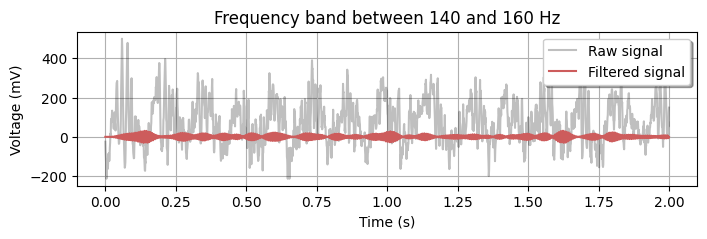

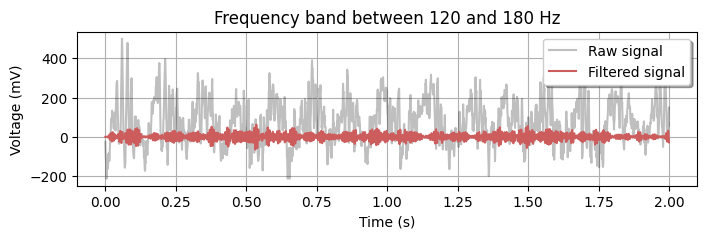

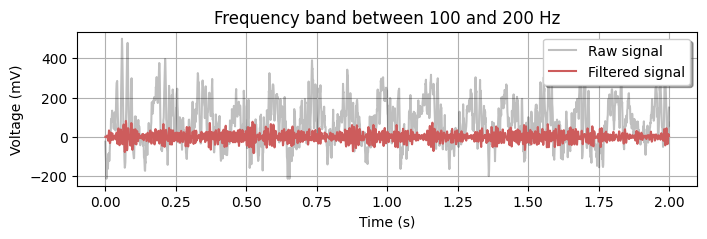

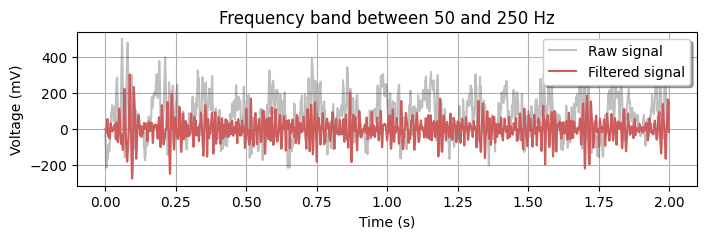

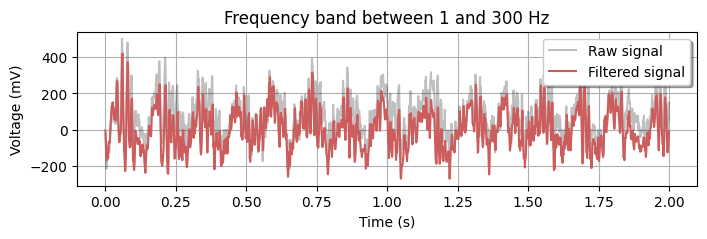

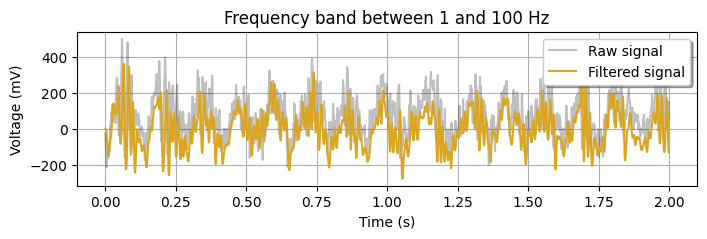

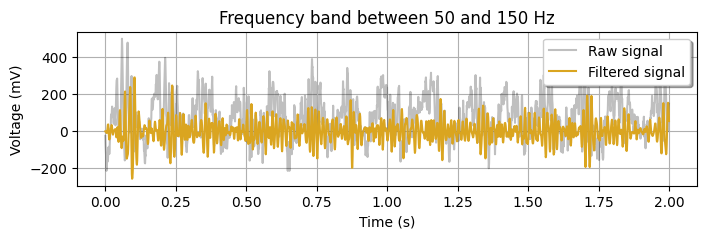

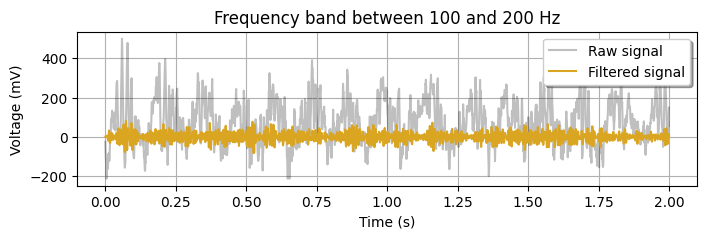

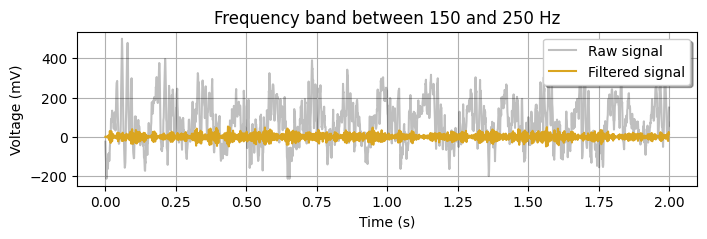

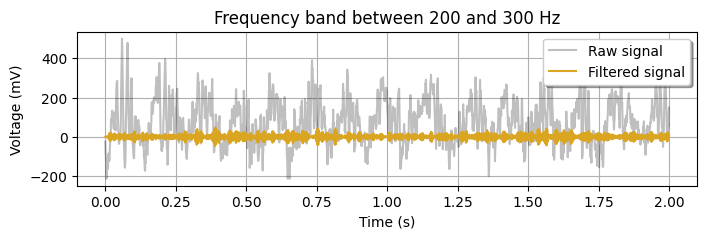

In [ ]:
from scipy.signal import butter, sosfilt

filter_order = 5
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)

# Fixing the central frequency and changing the width
frequency_bands1 = [[140,160], [120,180],[100,200],[50,250],[1,300]]

for indx in range(len(frequency_bands1)):
    filter = butter(filter_order, frequency_bands1[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='indianred')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands1[indx][0], frequency_bands1[indx][1]))
    plt.show()

# Fixing the bandwidth and changing center 
frequency_bands2 = [[1,100],[50,150],[100,200],[150,250],[200,300]]

for indx in range(len(frequency_bands2)):
    filter = butter(filter_order, frequency_bands2[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='goldenrod')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands2[indx][0], frequency_bands2[indx][1]))
    plt.show()

From the plots above, we conclude that:

1. By chaging the range with fixed center, more frequencies are included in the resulting signal. More frequencies translate to greater oscillations and more resemblance with the original signal.

2. By chaging the center with fixed range, the same number of frequencies are included however depending on the original signal (more low frequencies or more high frequencies) chaging the center will have a different impact. In this case, we see that the original signal has more low frequencies which is corroborated the decreasing resemblance between filtered and original signal as the center frequency increases.


The choice of what filter to use can also be problem specific. However, one must also take into account the computational cost of each filter. Small datasets may not run into such a problem but for more complex analysis it is an important factor. The extra parameter specific to the Butterwoth filter, the order, has an impact on the computation time. Next, we explore that by chaging the filter's order whilst keepinf the range and center of the frequency band fixed.

Text(0, 0.5, 'Computation time')

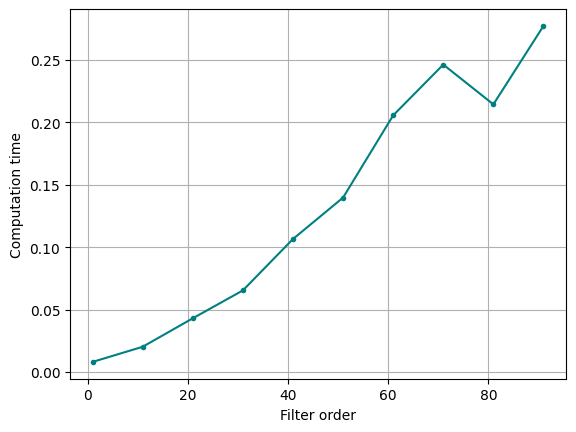

In [ ]:
import time

filter_orders = np.arange(1,100,10)
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)
elapsed_times = []

for order in filter_orders:

    start = time.time()
    filter = butter(order, [1,200], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)
    end = time.time()
    elapsed_times.append(end - start)

# PLOT ELAPSED TIMES WITH INCREASING FILTER_ORDER
plt.plot(filter_orders, elapsed_times, '.-', color='teal')
plt.grid()
plt.xlabel('Filter order')
plt.ylabel('Computation time')

There is a clear increase in computation time associated with increasing the order of the filter. As such, although increasing the prder of the filter has its advantages specific to this filter (for instance, higher SNR), there is a trade-off between those advatages and the computation time.

#### <font color='indianred'> Exercise 3 </font>

In this exercise, a code was implemented to detect REM and non-REM sleep based on the difference between the power of theta and delta frequency oscillations with frequency bands of (6 - 10) Hz and (2 - 4) Hz, respectively. This goes in line with the exercise shown in the lectures for ripple detection.

The approach takes the following steps:

1. Extract the instantaneous power in each frequency band (with the pre-processing this requires)
2. Standardize the data
3. Compute the power difference 
4. Separate REM from non-REM sleep based on a threshold.

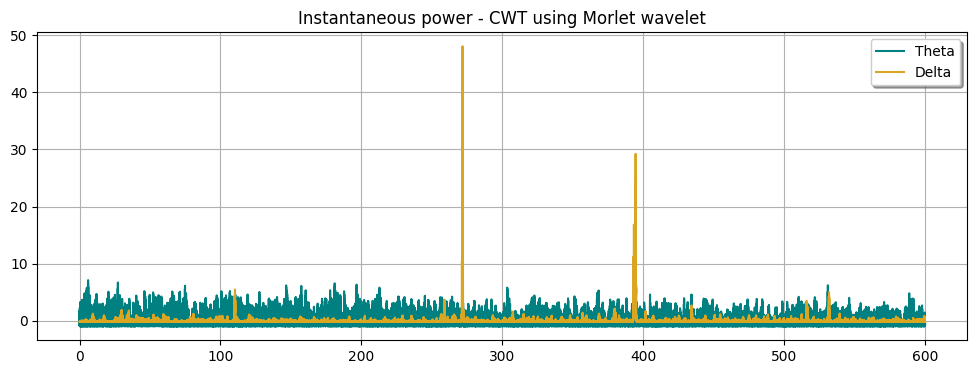

In [ ]:
import pywt
def instantaneous_power(signal, sp, band):
    '''
    Computes the instantaneous power. To preserve the time evolution/information, 
    a continuous wavelet transform is used.'''

    # Detrending
    signal -= np.mean(signal)

    # Apply Continuous Wavelet Transform
    freqs = np.linspace(band[0], band[1], 50) / sp
    scales = pywt.scale2frequency('morl', freqs)
    cwt, _ = pywt.cwt(signal, scales, 'morl')

    # Compute the power 
    power = np.mean(abs(cwt)**2, axis = 0)

    return power

# Theta and delta frequency bands
theta_band, delta_band = [6,10], [2,4]
theta_power = instantaneous_power(lfp, sampling_rate, theta_band)
delta_power = instantaneous_power(lfp, sampling_rate, delta_band)

# Standardize (z-scoring) the data
from scipy.stats import zscore
theta_power = zscore(theta_power)
delta_power = zscore(delta_power)

# Plotting the instantaneous power 
time = np.linspace(0, len(lfp)/sampling_rate, len(lfp))
plt.figure(figsize=(12,4))
plt.title('Instantaneous power - CWT using Morlet wavelet')
plt.grid()
plt.plot(time, theta_power, color='teal', label='Theta')
plt.plot(time, delta_power, color='goldenrod', label='Delta')
plt.legend(shadow=True)

(0.0, 100.0)

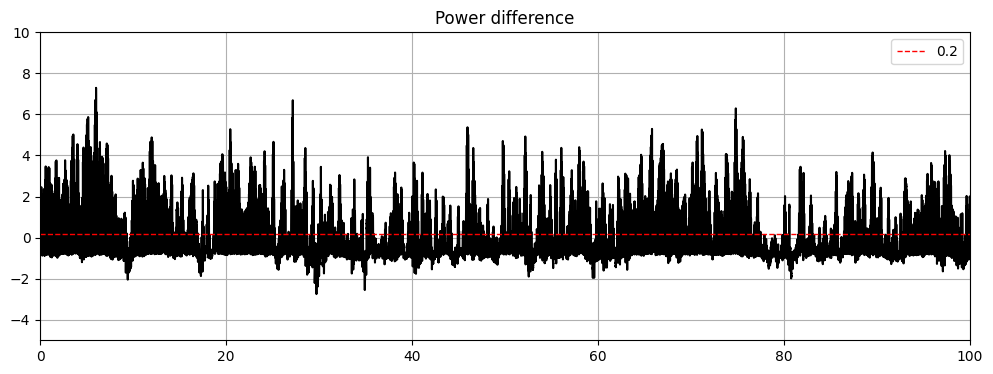

In [ ]:
power_difference = theta_power - delta_power

plt.figure(figsize=(12,4))
plt.title('Power difference')
plt.grid()
plt.plot(time, power_difference, color='k')
plt.axhline(y = 0.2, color='red', linewidth=1, linestyle='--', label ='0.2')
plt.legend()
plt.ylim([-5, 10])
plt.xlim([0, 100])

Following what was implemented for the ripple detection, we implement the `finding_sleep_regimes` below. This function takes as argument a 'mask' which is built based on a threshold. After taking the difference of the power spetcrum of the two oscillation regimes, we assign REM sleep to the time intervals when the difference is above said threshold and vice versa for non-REM sleep, thus constructing the two masks.

The function `finding_sleep_regimes` then takes those masks and identifies when each sleep regime starts and ends. The ouput is the time intervals when each sleep regime occurs. 

**Here, I find my problem (or at least question). I always get equal numbers of REM and non-REM intervals though the masks have different sizes and I believe this is wrong though I cannot pin point why**

Found 6374 periods of REM sleep and 6374 periods of nREM sleep


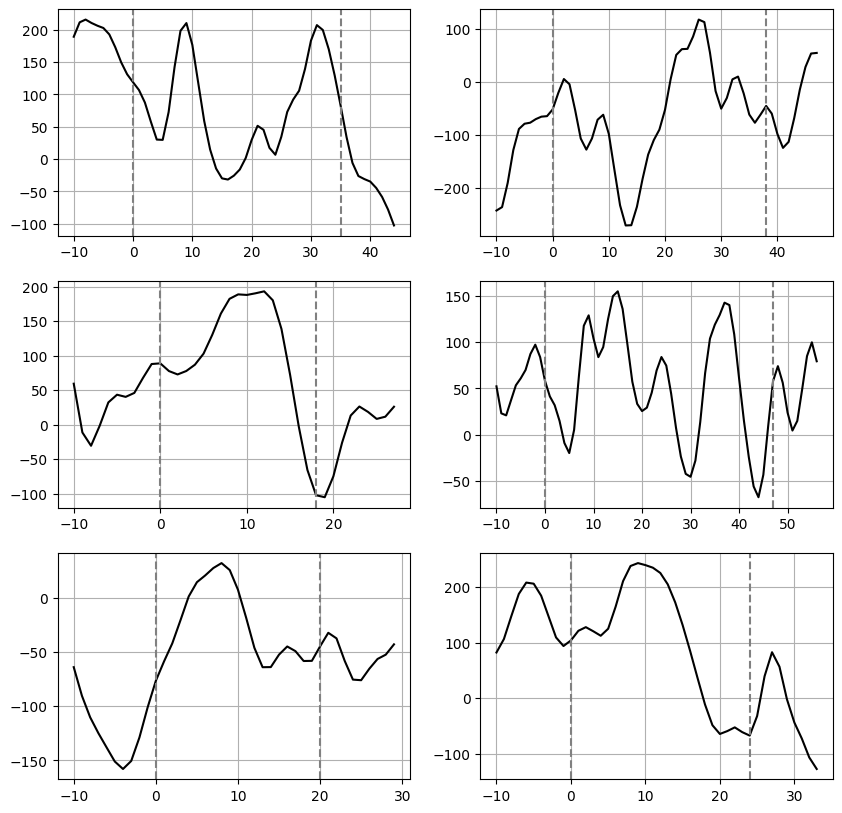

In [ ]:
# Thresholds
power_dif_threshold = 0.2

# Building each sleep regime's mask
rem_mask = np.asarray([True if x > power_dif_threshold else False for x in power_difference])
nrem_mask = np.asarray([True if x < power_dif_threshold else False for x in power_difference])

def finding_sleep_regimes(sleep_mask): # Cucumber disks over the eyes ahahah
    sleep_starts, sleep_ends = [], []

    for i in range(1, len(sleep_mask)):
        if sleep_mask[i-1] == 0 and sleep_mask[i] == 1:
            sleep_starts.append(i)
        if sleep_mask[i-1] == 1 and sleep_mask[i] == 0:
            sleep_ends.append(i)
    
    if len(sleep_ends) > len(sleep_starts):
        sleep_starts = [0] + sleep_starts  # if session starts with sleeping regime

    if len(sleep_ends) < len(sleep_starts):
        sleep_ends.append(len(sleep_mask))  # if session ends with sleeping regime

    sleeps = [np.arange(sleep_starts[i], sleep_ends[i])
               for i in range(len(sleep_starts))]
    
    return sleeps

rem_sleeps = finding_sleep_regimes(rem_mask)
nrem_sleeps = finding_sleep_regimes(nrem_mask)
print('Found {} periods of REM sleep and {} periods of nREM sleep'.format(len(rem_sleeps), len(nrem_sleeps)))

# Plotting some examples of REM sleep (BANDPASS FILTERED!!!)
sleep_lfp = lf.bandpass_filter(lfp, 1,200, sampling_rate) 

# REM SLEEP
selected_sleep_periods = np.arange(1,7) * 1000
rem_lengths  = [len(rem_sleeps[i]) for i in selected_sleep_periods]

plt.figure(figsize=(10,10))
for i,period in enumerate(selected_sleep_periods):
    
    rem_sleep_onset = rem_sleeps[period][0]
    x = np.arange(-10, rem_lengths[i]+10)
    #y_theta, y_delta = theta_power[rem_sleep_onsett-10: rem_sleep_onset+100], delta_power[rem_sleep_onset-10: rem_sleep_onset+100]
    y = sleep_lfp[rem_sleep_onset - 10: rem_sleep_onset + rem_lengths[i] + 10]
    
    plt.subplot(3, 2, i+1)
    plt.plot(x, y, color='k')
    plt.axvline(x = 0, color='grey',linestyle='--', label='Onset of REM sleep')
    plt.axvline( x = rem_lengths[i], color='grey',linestyle='--', label='End of REM sleep')
    plt.grid()

Assuming that these intervals are correct, I can't seem to extract anything meaningful from them. I only note that for the recommend threshold the intervals I detect feel way too small as if the mice are switching from REM to non-REM sleep very fast which to me doesn't seem plausible.

Text(0, 0.5, '# REM sleep intervals')

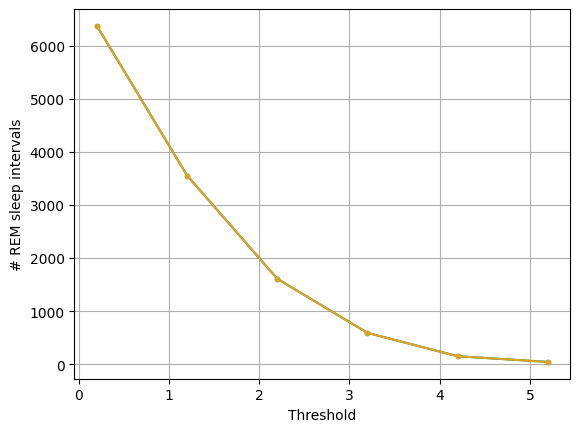

In [ ]:
# Thresholds
power_dif_thresholds = np.arange(0.2, 5.3,1)
rems, n_rems = [], []

for power_dif_threshold in power_dif_thresholds:
    
    # Building each sleep regime's mask
    rem_mask = np.asarray([True if x > power_dif_threshold else False for x in power_difference])
    nrem_mask = np.asarray([True if x < power_dif_threshold else False for x in power_difference])

    rem_sleeps = finding_sleep_regimes(rem_mask)
    nrem_sleeps = finding_sleep_regimes(nrem_mask)

    rems.append(len(rem_sleeps))
    n_rems.append(len(nrem_sleeps))

plt.plot(power_dif_thresholds, rems, '.-', color='teal')
plt.plot(power_dif_thresholds, n_rems, '.-', color='goldenrod')
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('# REM sleep intervals')

Nonetheless, we see that with increasing threshold the number of detected intervals decreases (as a result of the problem I mentioned before, the curves for REM and non-REM sleep are equal). However, I don't know if this expected behaviour and if so what is the reason behind it. I hope I can get some light shed on this from the feedback, otherwise I'll use the practical time for that.